In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
df = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# 1. Preprocessing and Cleaning

## 1.1. Missing Values

In [6]:
print(df.isna().sum()*100/df.shape[0])


job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.072707
benefits               40.324385
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


In [10]:
to_drop = ['job_id','title','department','salary_range','company_profile','requirements','benefits']

df = df.drop(to_drop, axis = 1).sort_index() #drop columns that aren't needed

df = df.dropna(subset = ['description', 'location'])
df.shape

(17533, 11)

## 1.2. Preprocessing

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [39]:
stemmer = PorterStemmer() 
stop_words = stopwords.words('english')

def preprocess(text):
    text = re.sub('[^a-zA-Z\s]', '', text) #tokenizatoin
    text = text.lower() #to lower case
    split = text.split() #getting rid of stop words and Porter2 stemming
    for word in split :
      if word in stop_words :
        word = ''
      else :
        stemmer.stem(word)
    return ' '.join([word for word in split])

df['description'] = df['description'].apply(preprocess)

df['description'].head()


(17533, 11)

## 1.3. Preparation of Dataset

In [41]:
#define the variables
x = df['description']
y = df['fraudulent']

#split it into training and test sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42)

#encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

#vectorization
MAX = 2000
vectorizer = TfidfVectorizer(max_features = MAX)
vectorizer.fit(x_train)

x_trainvec = vectorizer.transform(x_train)
x_testvec = vectorizer.transform(x_test)



# 2. Model

## 2.1. Base Models

### 2.1.1. Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

# fit 
logreg = LogisticRegression()
logreg.fit(x_trainvec, y_train)

# predict
y_pred_lr = logreg.predict(x_testvec)

# accuracy
print("Accuracy Score of LogReg :", accuracy_score(y_pred_lr, y_test), "\n") #96.3%

# confusion matrix 
print("Confusion Matrix of LogReg:\n", confusion_matrix(y_test, y_pred_lr), "\n") # [[3324, 0], [128, 55]]

#classifcation report
print("Classification Report of LogReg:\n", classification_report(y_test, y_pred_lr), "\n")

Accuracy Score of LogReg : 0.9635015682919874 

Confusion Matrix of LogReg:
 [[3324    0]
 [ 128   55]] 

Classification Report of LogReg:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3324
           1       1.00      0.30      0.46       183

    accuracy                           0.96      3507
   macro avg       0.98      0.65      0.72      3507
weighted avg       0.96      0.96      0.95      3507
 



### 2.1.2. KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid={'n_neighbors':range(1,40)}, scoring='accuracy')
grid.fit(x_trainvec, y_train)

grid.best_params_

for i in range(0, len(grid.cv_results_['mean_test_score'])):
    print('N_Neighbors {}: {} '.format(i+1, grid.cv_results_['mean_test_score'][i]*100))

N_Neighbors 1: 97.70427515268402 
N_Neighbors 2: 97.35491428477047 
N_Neighbors 3: 97.39057761379676 
N_Neighbors 4: 97.21231687128295 
N_Neighbors 5: 97.26222012163902 
N_Neighbors 6: 97.14101816453919 
N_Neighbors 7: 97.11249766543047 
N_Neighbors 8: 96.99841312796744 
N_Neighbors 9: 96.9057367520325 
N_Neighbors 10: 96.78452971287655 
N_Neighbors 11: 96.6989809206907 
N_Neighbors 12: 96.56349838581193 
N_Neighbors 13: 96.52072017817689 
N_Neighbors 14: 96.50647009273483 
N_Neighbors 15: 96.48507971840328 
N_Neighbors 16: 96.49220476112431 
N_Neighbors 17: 96.46368680304364 
N_Neighbors 18: 96.4850771773752 
N_Neighbors 19: 96.47081184576469 
N_Neighbors 20: 96.47081438679275 
N_Neighbors 21: 96.46368426201558 
N_Neighbors 22: 96.37813292880166 
N_Neighbors 23: 96.3710104271087 
N_Neighbors 24: 96.3068342220579 
N_Neighbors 25: 96.30683168102983 
N_Neighbors 26: 96.2284003084808 
N_Neighbors 27: 96.24266055803517 
N_Neighbors 28: 96.20702518031771 
N_Neighbors 29: 96.19989505554052 


In [43]:
knn1 = knn = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(x_trainvec, y_train)

y_pred_knn = knn1.predict(x_testvec)

# accuracy
print("Accuracy Score of KNN :", accuracy_score(y_pred_knn, y_test), "\n") #97.9%

# confusion matrix 
print("Confusion Matrix of KNN:\n", confusion_matrix(y_test, y_pred_knn), "\n") # [[3314, 10], [61, 122]]

# classifcation report
print("Classification Report of KNN:\n", classification_report(y_test, y_pred_knn), "\n")


Accuracy Score of KNN : 0.9797547761619618 

Confusion Matrix of KNN:
 [[3314   10]
 [  61  122]] 

Classification Report of KNN:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3324
           1       0.92      0.67      0.77       183

    accuracy                           0.98      3507
   macro avg       0.95      0.83      0.88      3507
weighted avg       0.98      0.98      0.98      3507
 



### 2.1.3. SVC

In [44]:
from sklearn.svm import SVC

svc = SVC(kernel = 'rbf')
svc.fit(x_trainvec, y_train)

y_pred_svc = svc.predict(x_testvec)

# accuracy
print("Accuracy Score of SVC :", accuracy_score(y_pred_svc, y_test), "\n") #97.3%

# confusion matrix 
print("Confusion Matrix of SVC:\n", confusion_matrix(y_test, y_pred_svc), "\n") # [[3324, 0], [96, 87]]

# classifcation report
print("Classification Report of SVC:\n", classification_report(y_test, y_pred_svc), "\n")

Accuracy Score of SVC : 0.9726261762189906 

Confusion Matrix of SVC:
 [[3324    0]
 [  96   87]] 

Classification Report of SVC:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      3324
           1       1.00      0.48      0.64       183

    accuracy                           0.97      3507
   macro avg       0.99      0.74      0.82      3507
weighted avg       0.97      0.97      0.97      3507
 



## 2.2. Comparision of Models and Discussion

### 2.2.1. Sensitivity, Specificity and Accuracy

If we look at the three models, all of them give us quite high of an accuracy (LR: 96.5%, KNN: 97.6%, SVC: 97.3%). 

However, this doesn't tell us much. The 'null accuracy' itself is 94.78%. This means that if we simply classify all job ads as real, we will still have a ~95% accuracy. Hence, accuracy cannot be a good way to asssess our models in this case.

Let's look at other metrics.

**Recall/TPF/Sensitivity (False Negative Rate):**

LR: 0.30 (0.70) , KNN: 0.67 (0.33) , SVC: 0.48 (0.52)

**Specificity/TNR (False Positive Rate):**

LR: 1 (0) , KNN: 0.997 (0.003) , SVC: 1 (0)


This is very interesting. Looking at the specificity, we can see that all models perform very well. Logistic Regression and SVC have a perfect TNR which means they haven't incorrectly classified any real job as fake. However, KNN is just a tad bit worse. It has classified approximately 10 real job ads as fake.

On the other hand, things look a little less rosy when we inspect Sensitivity. KNN outperforms both LR and SVC here with a Sensitivity of 0.67. This means that it accurately classified 67% of all fake job ads as fake (the rest, ostensibly, as real job ads). Hence, all our models give a lot of false negatives. 



In [45]:
print(1 - y_test.mean()) #null accuracy

0.9478186484174508


### 2.2.2. ROC Curves and AUC

If we look at the ROC curves, we can see that KNN clearly outperforms LR and SVC. Hence, if we have to pick one model, we should pick KNN. But it is necessary to remember that KNN's specificity is not perfect. 


                                      fpr                              tpr  \
models                                                                       
LR                        [0.0, 0.0, 1.0]   [0.0, 0.3005464480874317, 1.0]   
KNN     [0.0, 0.0030084235860409147, 1.0]   [0.0, 0.6666666666666666, 1.0]   
SVC                       [0.0, 0.0, 1.0]  [0.0, 0.47540983606557374, 1.0]   

             auc  
models            
LR      0.650273  
KNN     0.831829  
SVC     0.737705  


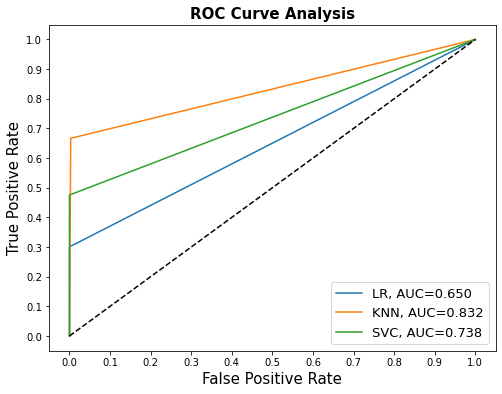

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score

results_table = pd.DataFrame(columns = ['models', 'fpr','tpr','auc'])

predictions = {'LR': y_pred_lr, 'KNN': y_pred_knn, 'SVC': y_pred_svc}

for key in predictions:
    fpr, tpr, _ = roc_curve(y_test, predictions[key])
    auc = roc_auc_score(y_test, predictions[key])
    
    results_table = results_table.append({'models': key,
                                         'fpr' : fpr,
                                         'tpr' : tpr,
                                         'auc' : auc}, ignore_index=True)
    
results_table.set_index('models', inplace=True)

print(results_table)

fig = plt.figure(figsize = (8,6))

for i in results_table.index:
    plt.plot(results_table.loc[i]['fpr'], 
             results_table.loc[i]['tpr'], 
             label = "{}, AUC={:.3f}".format(i, results_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color = 'black', linestyle = '--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop = {'size':13}, loc = 'lower right')

plt.show()

### 2.2.3. Implications

The good thing about all our models is that they all have high Specificity. There are hardly any real jobs being classified as fake (only 10 in KNN's case, otherwise none). This is very important in the practical sense as any job portal wouldn't want to classify a real job posting as a fake one, since it can be damaging for the company. 

On the other hand, the Sensitivity tells us that there is a sizable chunk of fake jobs that are being classified as real ones. This is not so troublesome for the companies but is a nuisance for applicants. A lot of them might unknowingly apply to fake jobs if the job portal wasn't able to correctly classify a posting as fake.

### NOTE

I will extend this notebook by testing a stacked model using the three base models that I've trained and see if it leads to an improvement.